In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from kalman import KalmanFilter

In [2]:
sns.set()

In [3]:
poi_x, poi_y = (2,5)
close_dist = 1.5
far_dist = 6
data_dir = 'data/exp1'

In [4]:
csv_files = [f for f in os.listdir(data_dir) if f.endswith(".csv")]

In [5]:
dfs = [
    pd.read_csv(os.path.join(data_dir, csv), parse_dates=['time']).assign(dataset_index=i + 1)
    for i, csv in enumerate(csv_files)
]

In [6]:
F = np.array([[1, 0], [0, 1]])
H = np.array([[1, 0], [0, 1]])
R = np.array([[4, 0], [0, 4]])
Q = np.array([[0.05, 0], [0, 0.05]])

In [7]:
df = dfs[1]

In [8]:
dff = df[(df['x'] != 0) & (df['y'] != 0) & (df['xp_step'] >= 0)].reset_index(drop=True)

In [9]:
step_times = [
    df[df['xp_step'] == s]['time'].iloc[0]
    for s
    in range(0, max(df['xp_step']+1))
]
step_times.append(max(df['time']))

In [10]:
step_times

[Timestamp('2025-02-17 18:09:35.229327'),
 Timestamp('2025-02-17 18:10:35.933891'),
 Timestamp('2025-02-17 18:10:44.974086'),
 Timestamp('2025-02-17 18:11:45.494690'),
 Timestamp('2025-02-17 18:12:25.495185')]

## Kalman Filter 1

In [11]:
kf = KalmanFilter(F=F, H=H, R=R, Q=Q, B=[0, 0])
filtered_positions = []
theorical_positions = []
for i, row in dff.iterrows():
    filtered_positions.append(np.dot(H,  kf.predict())[0])
    kf.update([row['x'], row['y']])

    if row['xp_step'] in [0, 4]:
        theorical_positions.append([8, 5])
    elif row['xp_step'] in [2]:
        theorical_positions.append([3, 5])
    elif row['xp_step'] in [1]:
        theorical_positions.append([8 - (row['time']-step_times[1]) / (step_times[2]-step_times[1]) * 5, 5])
    elif row['xp_step'] in [3]:
        theorical_positions.append([ (row['time']-step_times[3]) / (step_times[4]-step_times[3]) * 5 + 3, 5])
    
dff['new_x'], dff['new_y'] = np.array(filtered_positions).T
dff['theorical_x'], dff['theorical_y'] = np.array(theorical_positions).T

In [12]:
dff['error_dist'] = ((dff['x']-dff['theorical_x'])**2 + (dff['y']-dff['theorical_y'])**2)**0.5
dff['error_new_dist'] = ((dff['new_x']-dff['theorical_x'])**2 + (dff['new_y']-dff['theorical_y'])**2)**0.5

## Kalman Filter 2

In [13]:
def kalman_predict(x, P, F, Q):
    """
    Prediction step of the Kalman filter.
    
    x : current state vector.
    P : current state covariance matrix.
    F : state transition matrix.
    Q : process noise covariance.
    
    Returns:
      x_pred : predicted state.
      P_pred : predicted state covariance.
    """
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

def kalman_update(x_pred, P_pred, z, H, R):
    """
    Update step (correction) of the Kalman filter.
    
    x_pred : predicted state vector.
    P_pred : predicted covariance matrix.
    z      : new measurement vector.
    H      : measurement matrix.
    R      : measurement noise covariance.
    
    Returns:
      x_upd : updated (posterior) state vector.
      P_upd : updated state covariance matrix.
    """
    # Compute the innovation (measurement residual)
    y = z - (H @ x_pred)
    
    # Compute the innovation covariance
    S = H @ P_pred @ H.T + R
    
    # Kalman Gain: how much to trust the measurement
    K = P_pred @ H.T @ np.linalg.inv(S)
    
    # Update state estimate
    x_upd = x_pred + K @ y
    
    # Update error covariance estimate
    I = np.eye(x_pred.shape[0])
    P_upd = (I - K @ H) @ P_pred
    return x_upd, P_upd

In [14]:
dt = 1

# State vector: [x, y, vx, vy]

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
Q = np.eye(4) * 0.0001
R = np.eye(2) * 10 #* 0.1
x_init = np.array([0, 0, 0, 0]).T
P_init = np.eye(4) * 1.0
alpha = 0.8

In [15]:
estimates = []
x = x_init.copy()
P = P_init.copy()
for i, row in dff.iterrows():
    dt = (row['time'] - dff.loc[i-1]['time']).total_seconds() if i > 0 else 1

    F = np.array([[1, 0, dt*alpha,  0],
                  [0, 1,  0, dt*alpha],
                  [0, 0,  1,  0],
                  [0, 0,  0,  1]])
    
    # Predict step using the constant-velocity model
    x, P = kalman_predict(x, P, F, Q)
    # Update step using the new measurement
    x, P = kalman_update(x, P, (row['x'], row['y']), H, R)
    estimates.append(x.copy())
estimates = np.array(estimates)
dff['new2_x'], dff['new2_y'], *_ = np.array(estimates).T
dff['error_new2_dist'] = ((dff['new2_x']-dff['theorical_x'])**2 + (dff['new2_y']-dff['theorical_y'])**2)**0.5

## Results

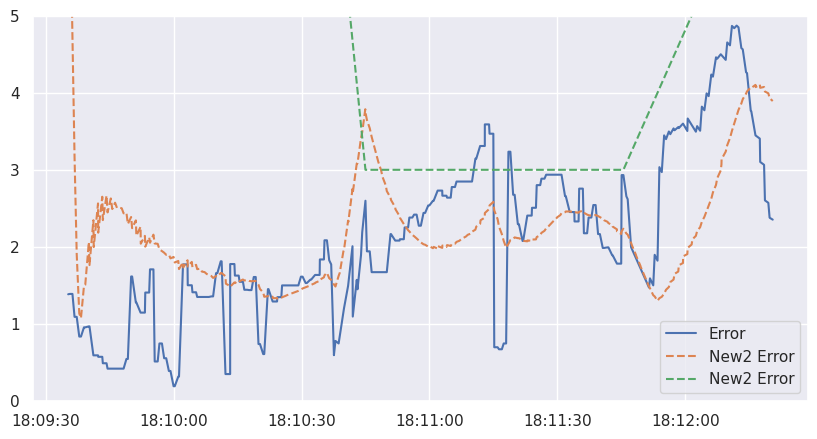

In [16]:
plt.figure(figsize=(10,5))
plt.plot(dff['time'], dff['error_dist'], label='Error')
#plt.plot(dff['time'], dff['error_new_dist'], '--', label='New Error')
plt.plot(dff['time'], dff['error_new2_dist'], '--', label='New2 Error')
plt.plot(dff['time'], dff['theorical_x'], '--', label='New2 Error')
plt.ylim((0, 5))
plt.legend()

AttributeError: 'list' object has no attribute 'T'

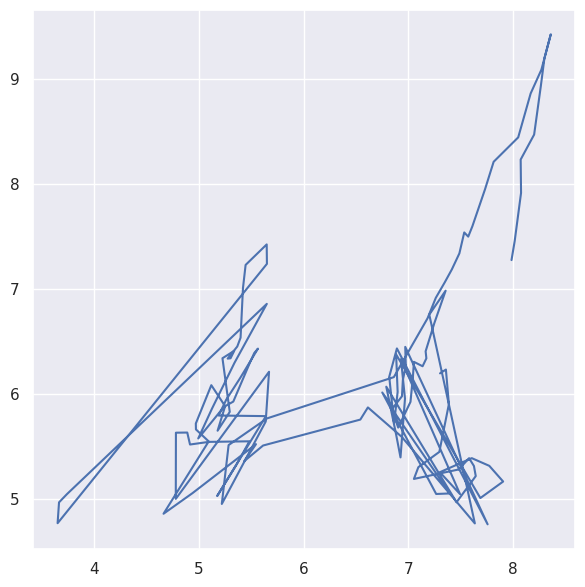

In [17]:
plt.figure(figsize=(7,7))
plt.plot(dff['x'], dff['y'])
plt.plot(*filtered_positions.T, '--')
plt.scatter(*np.array([[1, 2.5], [10, 2.5], [7, 10]]).T, color='blue')
plt.scatter(*np.array([[2, 5]]).T, color='red')
plt.scatter(*np.array([[3, 5], [8, 5]]).T, color='black')

In [18]:
fdd = [el[0] if not np.isnan(el) else el for el in filtered_distances]

NameError: name 'filtered_distances' is not defined

NameError: name 'fdd' is not defined

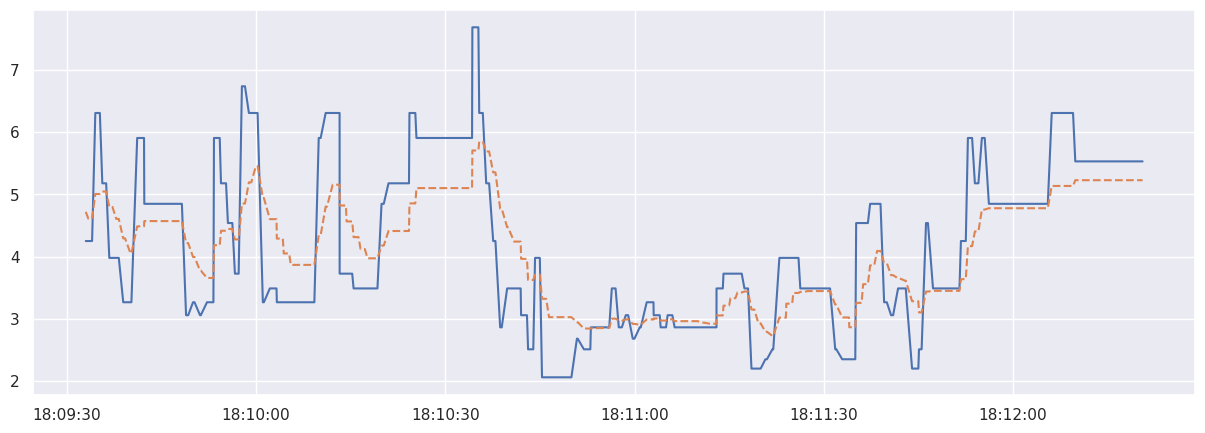

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(df['time'], df['ESP32-1_raw_dist'], label='Raw dist')
plt.plot(df['time'], df['ESP32-1_filtered_dist'], '--', label='dist')
plt.plot(df['time'], fdd, '--', label='new_dist')

for i, st in enumerate(step_times):
    plt.axvline(x=st, linestyle='-', color='red', label='Step time' if i == 0 else None)

plt.plot([step_times[0], step_times[1]], [far_dist, far_dist], 'black', ls='--', label='Theorical distance')
plt.plot([step_times[1], step_times[2]], [far_dist, close_dist], 'black', ls='--')
plt.plot([step_times[2], step_times[3]], [close_dist, close_dist], 'black', ls='--')
plt.plot([step_times[3], step_times[3] + pd.Timedelta(seconds=8)], [close_dist, far_dist], 'black', ls='--') 
plt.plot([step_times[3] + pd.Timedelta(seconds=8), max(df['time'])], [far_dist, far_dist], 'black', ls='--') 

plt.legend()